In [20]:
import torch
import torch.fft
import numpy as np
import matplotlib.pyplot as plt
from torch_radon import Radon
from skimage.data import shepp_logan_phantom

device = torch.device("cuda")

In [21]:
# 1. 데이터 준비 (H, W는 반드시 16의 배수여야 함)
img_np = shepp_logan_phantom().astype(np.float32)
image = torch.from_numpy(img_np).unsqueeze(0).unsqueeze(0).to(device)
H, W = image.shape[-2:]

In [31]:
# 2. Radon 설정 (30 views Sparse-view)
num_views = 90
angles = torch.linspace(0, np.pi, num_views).to(device)
radon = Radon(resolution=H, angles=angles, clip_to_circle=False)

In [32]:
with torch.no_grad():
    # A. Forward Projection
    sinogram = radon.forward(image)
    
    # B. Minimal Filtering (구버전 torch.rfft 에러 회피용)
    # n 인자를 주면 자동으로 2의 거듭제곱 패딩이 적용되어 품질이 유지됨
    padded_size = max(64, int(2 ** np.ceil(np.log2(2 * sinogram.size(-1)))))
    sino_fft = torch.fft.fft(sinogram, n=padded_size, dim=-1)
    
    # 표준 Ramp Filter 적용
    freq = torch.fft.fftfreq(padded_size, device=device)
    ramp_filter = freq.abs()
    filtered_sino = torch.fft.ifft(sino_fft * ramp_filter, dim=-1).real[..., :sinogram.size(-1)]
    
    # C. Backprojection & Scaling
    # Scaling은 iradon 수식의 핵심이므로 반드시 포함 (pi / 2*views)
    reconstruction = radon.backprojection(filtered_sino.contiguous()) * (np.pi / (2 * num_views))

# 3. 결과 확인 (0~1 클램핑만 수행)
reconstruction = torch.clamp(reconstruction, 0, 1)

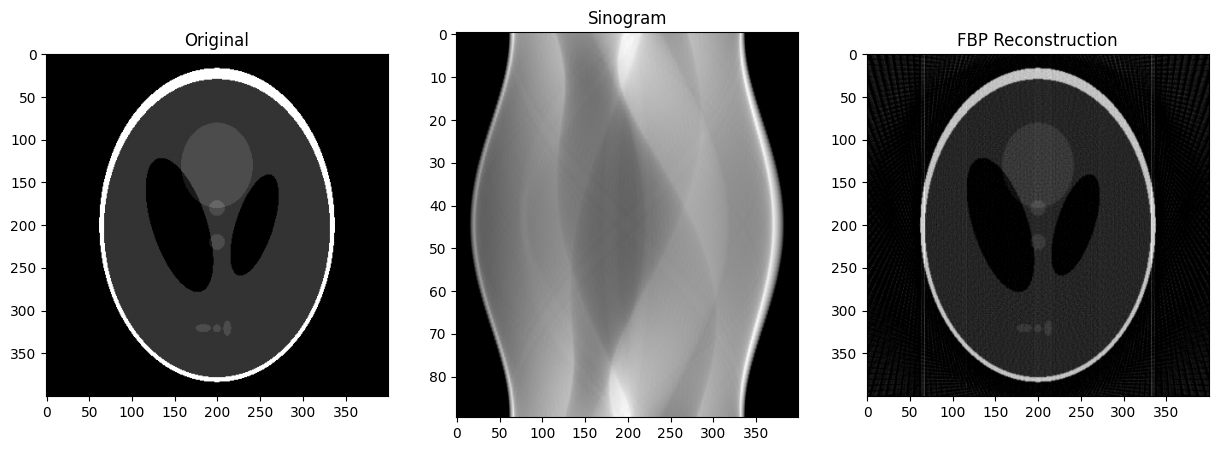

In [33]:
# 5. 결과 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img_np, cmap='gray')
axes[0].set_title("Original")

axes[1].imshow(sinogram.squeeze().cpu().numpy(), cmap='gray', aspect='auto')
axes[1].set_title("Sinogram")

# 복원 결과물 시각화 최적화
recon_np = reconstruction.squeeze().cpu().numpy()
axes[2].imshow(recon_np, cmap='gray')
axes[2].set_title("FBP Reconstruction")

plt.show()